In [79]:
# Import Dependencies
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

In [105]:
df = pd.read_csv(r"C:\Users\HITES\Fintech\fraud_detection_dataset.csv")
print("✅ Dataset Loaded Successfully\n")

✅ Dataset Loaded Successfully



In [107]:
print("First 5 rows:")
print(df.head(), "\n")

First 5 rows:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0   



In [109]:
print("Dataset Info:")
print(df.info(), "\n")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None 



In [111]:
print("Missing Values per Column:")
print(df.isnull().sum(), "\n")

Missing Values per Column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64 



In [113]:
print("Fraud Class Distribution:")
print(df['isFraud'].value_counts(), "\n")

Fraud Class Distribution:
isFraud
0    6354407
1       8213
Name: count, dtype: int64 



In [115]:
# Segregate legitimate and fraud transactions
legit = df[df.isFraud == 0]
fraud = df[df.isFraud == 1]

In [117]:
print(f"Legitimate transactions: {len(legit)}")
print(f"Fraudulent transactions: {len(fraud)}")
print("\n")

Legitimate transactions: 6354407
Fraudulent transactions: 8213




In [119]:
# Statistical Information
print("Statistical Information - Legitimate Transactions:")
print(legit.amount.describe())
print("\n")

Statistical Information - Legitimate Transactions:
count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64




In [121]:
print("Statistical Information - Fraudulent Transactions:")
print(fraud.amount.describe())
print("\n")

Statistical Information - Fraudulent Transactions:
count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64




In [123]:
# Mean values for both types of transactions
print("Mean values by transaction type:")
print(df.groupby('isFraud').mean(numeric_only=True))
print("\n")

Mean values by transaction type:
               step        amount  oldbalanceOrg  newbalanceOrig  \
isFraud                                                            
0        243.235663  1.781970e+05   8.328287e+05   855970.228109   
1        368.413856  1.467967e+06   1.649668e+06   192392.631836   

         oldbalanceDest  newbalanceDest  isFlaggedFraud  
isFraud                                                  
0          1.101421e+06    1.224926e+06        0.000000  
1          5.442496e+05    1.279708e+06        0.001948  




In [125]:
# Create new features
df['balanceChangeOrig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['balanceChangeDest'] = df['newbalanceDest'] - df['oldbalanceDest']

In [127]:
df['errorBalanceOrig'] = df['amount'] + df['balanceChangeOrig']
df['errorBalanceDest'] = df['amount'] - df['balanceChangeDest']

In [129]:
# Encode categorical variable 'type'
if 'type' in df.columns:
    le = LabelEncoder()
    df['type_encoded'] = le.fit_transform(df['type'])
    print("Transaction types:")
    print(df['type'].value_counts())
    print("\n")
    features_to_use = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 
                       'oldbalanceDest', 'newbalanceDest', 'type_encoded',
                       'balanceChangeOrig', 'balanceChangeDest', 
                       'errorBalanceOrig', 'errorBalanceDest']
else:
    print("Note: 'type' column not found. Proceeding without it.")
    features_to_use = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 
                       'oldbalanceDest', 'newbalanceDest',
                       'balanceChangeOrig', 'balanceChangeDest', 
                       'errorBalanceOrig', 'errorBalanceDest']

Transaction types:
type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64




In [131]:
# UNDER SAMPLING - Sample legitimate transactions to match fraud count
fraud_count = len(fraud)
legit_sample = legit.sample(n=fraud_count, random_state=42)

In [133]:
print(f"Sample sizes - Legit: {legit_sample.shape}, Fraud: {fraud.shape}")
print("\n")

Sample sizes - Legit: (8213, 11), Fraud: (8213, 11)




In [135]:
# Create balanced dataset
df_balanced = pd.concat([legit_sample, fraud], axis=0)
print(f"Balanced dataset shape: {df_balanced.shape}")
print("\n")

Balanced dataset shape: (16426, 11)




In [137]:
# Define features to use (filter only existing columns)
all_possible_features = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 
                         'oldbalanceDest', 'newbalanceDest', 'type_encoded',
                         'balanceChangeOrig', 'balanceChangeDest', 
                         'errorBalanceOrig', 'errorBalanceDest']

In [139]:
# Use only features that exist in the dataframe
features_to_use = [f for f in all_possible_features if f in df_balanced.columns]
print(f"Features being used: {features_to_use}")
print("\n")

Features being used: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']




In [141]:
# Define independent and dependent variables
X = df_balanced[features_to_use]
Y = df_balanced['isFraud']

In [143]:
# Splitting data into training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, stratify=Y, random_state=42
)

print(f"X shape: {X.shape}, X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"Y shape: {Y.shape}, Y_train shape: {Y_train.shape}, Y_test shape: {Y_test.shape}")
print("\n")

X shape: (16426, 6), X_train shape: (13140, 6), X_test shape: (3286, 6)
Y shape: (16426,), Y_train shape: (13140,), Y_test shape: (3286,)




In [145]:
# Create and train the model with pipeline
model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))
model.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [147]:
# Make predictions
training_data_predictions = model.predict(X_train)
test_data_predictions = model.predict(X_test)

In [149]:
# Evaluate the model
train_accuracy = accuracy_score(Y_train, training_data_predictions) * 100
test_accuracy = accuracy_score(Y_test, test_data_predictions) * 100

In [151]:
print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Testing Accuracy: {test_accuracy:.2f}%")
print("\n")

Training Accuracy: 89.03%
Testing Accuracy: 88.59%




In [153]:
print("Test Set Metrics:")
print(f"Precision: {precision_score(Y_test, test_data_predictions):.4f}")
print(f"Recall: {recall_score(Y_test, test_data_predictions):.4f}")
print("\n")

Test Set Metrics:
Precision: 0.9662
Recall: 0.7998




In [155]:
# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(Y_test, test_data_predictions)
print(cm)
print("\n")

Confusion Matrix:
[[1597   46]
 [ 329 1314]]




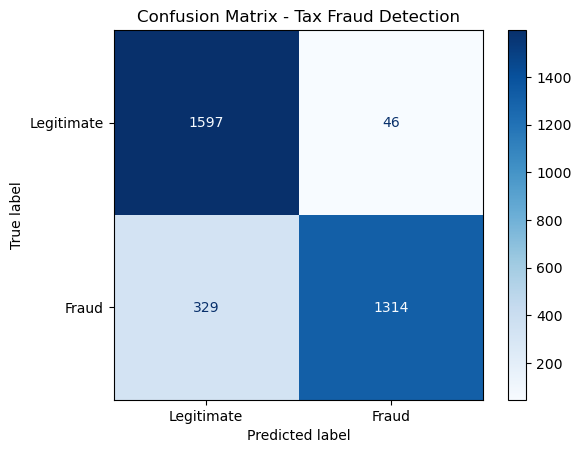

In [157]:
# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legitimate', 'Fraud'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Tax Fraud Detection')
plt.show()